## Exporting the results to PDF

Once you complete the assignments, export the entire notebook as PDF and attach it to your homework solutions. 
The best way of doing that is
1. Run all the cells of the notebook.
2. Export/download the notebook as PDF (File -> Download as -> PDF via LaTeX (.pdf)).
3. Concatenate your solutions for other tasks with the output of Step 2. On linux, you can use `pdfunite`, there are similar tools for other platforms, too. You can only upload a single PDF file to Moodle.

Make sure you are using `nbconvert` version 5.5 or later by running `jupyter nbconvert --version`. Older versions clip lines that exceed page width, which makes your code harder to grade.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.datasets import load_sample_image

%matplotlib inline

def compare_images(img, img_compressed, k):
    """Show the compressed and uncompressed image side by side.
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))
    axes[0].set_axis_off()
    if isinstance(k, str):
        axes[0].set_title(k)
    else:
        axes[0].set_title(f"Compressed to {k} colors")
    axes[0].imshow(img_compressed)
    axes[1].set_axis_off()
    axes[1].set_title("Original")
    axes[1].imshow(img)

# K-Means

In this first section you will implement the image compression algorithm from Bishop, chapter 9.1.1. Take an RGB image $X \in \mathbb{R}^{h \times w \times 3}$ and interpret it as a data matrix $X \in \mathbb{R}^{N \times 3}$. Now apply $k$-means clustering to find $k$ colors that describe the image well and replace each pixel with its associated cluster.

In [2]:
# Alternatively try china.jpg
X = load_sample_image("flower.jpg")

# or load your own image
#X = np.array(Image.open("/path/to/photo.jpg"))

In [12]:
def kmeans(X, k):
    """Compute a k-means clustering for the data X.
    
    Parameters
    ----------
    X : np.array of size N x D
        where N is the number of samples and D is the data dimensionality
    k : int
        Number of clusters
        
    Returns
    -------
    mu : np.array of size k x D
        Cluster centers
    z : np.array of size N
        Cluster indicators, i.e. a number in 0..k - 1, for each data point in X
    """

    mu = np.zeros((k,X.shape[1]))
    z = np.zeros(X.shape[0], dtype=int)
    N = X.shape[0]
    Nk = np.zeros(k)

    mu[0] = X[np.random.randint(0, N+1)]
    for idx in range(k-1):
        mu[idx] = X[np.argmax(np.linalg.norm(
            (X[:, None, :]-mu), axis=2).sum(axis=1))]

    prev = X
    while True:    
        z = np.argmin(np.linalg.norm((X[:, None, :] - mu), axis=2), axis=1)
        z_ik = np.zeros((N, k))
        for i in range(N):
            z_ik[i, z[i]] = 1

        for i in range(k):
            Nk[i] = (z==i).sum()
            mu[i] = (z_ik[:,i].T @ X) / Nk[i]

        new = mu[z].reshape(X.shape).astype(np.uint8)

        if (np.allclose(prev, new)):
            break
        prev = new
    return mu, z


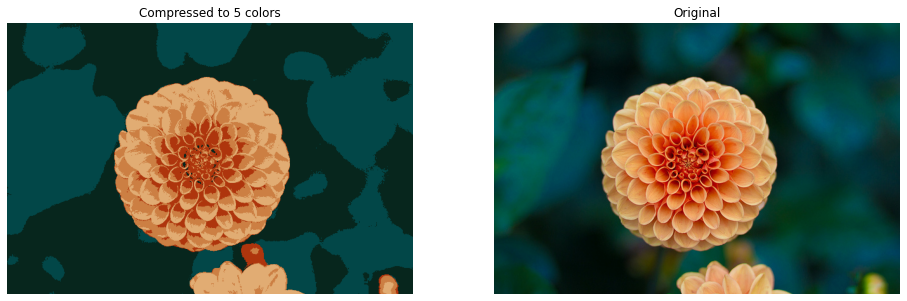

In [13]:
# Cluster the color values
k = 5
mu, z = kmeans(X.reshape((-1, 3)), k)

# Replace each pixel with its cluster color
X_compressed = mu[z].reshape(X.shape).astype(np.uint8)

# Show the images side by side
compare_images(X, X_compressed, k)

# Gaussian Mixture Models & EM

Now you will repeat the same exercise with GMMs.

In [75]:
def gmm_log_probability(X, pi, mu, sigma):
    """Compute the joint log-probabilities for each data point and component.
    
    Parameters
    ----------
    X : np.array of size N x D
        where N is the number of samples and D is the data dimensionality
    pi : np.array of size k
        Prior weight of each component
    mu : np.array of size k x D
        Mean vectors of the k Gaussian component distributions
    sigma : np.array of size k x D x D
        Covariance matrices of the k Gaussian component distributions
    
    Returns
    -------
    P : np.array of shape N x k
        P[i, j] is the joint log-probability of data point i under component j
    """

    N = X.shape[0]
    k, D = mu.shape

    P = np.empty((N, k))

    dets = np.empty(k)
    invs = np.empty((k, D, D))

    for i in range(k):
        dets[i] = np.linalg.det(sigma[i])
        invs[i] = np.linalg.inv(sigma[i])

    pdf = lambda x, mu_k, sigk_det, sigk_inv:  np.exp(-1/2* (x-mu_k).T @ sigk_inv @ (x-mu_k)) / \
        np.sqrt((2*np.pi)**k * sigk_det)

    for i in range(N):
        probs = np.empty(k)
        for j in range(k):
            probs[j] = pi[j] * pdf(X[i], mu[j], dets[j], invs[j])
        
        s = np.sum(probs)
        for j in range(k):
            P[i, j] = np.log(probs[j]) - np.log(s)
    return P
   

def em(X, k, tol=0.001):
    """Fit a Gaussian mixture model with k components to X.
    
    Parameters
    ----------
    X : np.array of size N x D
        where N is the number of samples and D is the data dimensionality
    k : int
        Number of clusters
    tol : float
        Converge when the increase in the mean of the expected  g-likelihood
        is lower than this
        
    The algorithm should stop when the improvement in the optimization
    objective is less than tol.
    
    Returns
    -------
    pi : np.array of size k
        Prior weight of each component
    mu : np.array of size k x D
        Mean vectors of the k Gaussian component distributions
    sigma : np.array of size k x D x D
        Covariance matrices of the k Gaussian component distributions
    """
    
    N = X.shape[0]
    D = X.shape[1]
    
    # inits
    pi = np.random.normal(size = k)
    mu = np.random.randint(0, 256, size=(k,D))
    sigma = np.empty((k,D,D))
    for i in range(k):
        sigma[i] = np.identity(D)

    for j in range(20):

        P = gmm_log_probability(X, pi, mu, sigma)
        N_k = P.sum(axis=0)
        mu = P.T @ X / N_k[:,None]

        distances = X[:,None,:] - mu    
            
        for i in range(k):
            sigma[i] = (P[:,i].reshape(-1, 1) * distances[:,i,:]).T @ distances[:,i,:] / N_k[i]

        pi = N_k/N

    return pi, mu, sigma


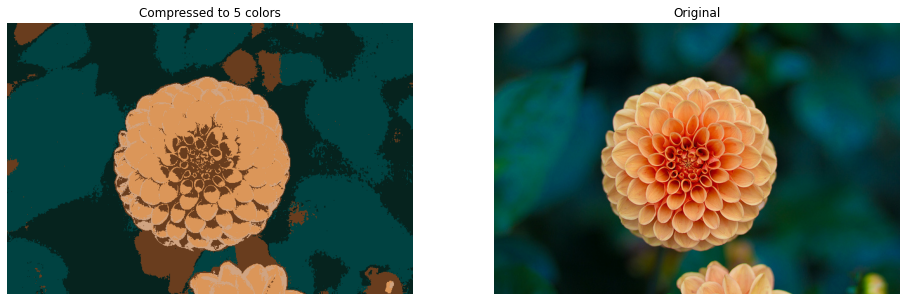

In [76]:
# Fit the GMM
k = 5
pi, mu, sigma = em(X.reshape((-1, 3)), k)

# Determine the most likely cluster of each pixel
log_p = gmm_log_probability(X.reshape((-1, 3)), pi, mu, sigma)
z = log_p.argmax(axis=1)

# Replace each pixel with its cluster mean
X_compressed = mu[z].reshape(X.shape).astype(np.uint8)

# Show the images side by side
compare_images(X, X_compressed, k)

# Sampling Unseen Datapoints

You have trained a generative model which allows you to sample from the learned distribution. In this section, you sample new images.

In [94]:
def gmm_sample(N, pi, mu, sigma):
    """Sample N data points from a Gaussian mixture model.
    
    Parameters
    ----------
    N : int
        Number of data points to sample
    pi : np.array of size k
        Prior weight of each component
    mu : np.array of size k x D
        Mean vectors of the k Gaussian component distributions
    sigma : np.array of size k x D x D
        Covariance matrices of the k Gaussian component distributions
    
    Returns
    -------
    X : np.array of shape N x D
    """
    
    X = np.empty((N, mu.shape[1]))
    
    samples = np.random.multinomial(1,pi,N)
    samples = np.argmax(samples, axis=1)
    
    for i in range(k):
        idx = (samples == i)
        X[idx] = np.random.multivariate_normal(mu[i], sigma[i])
    return X


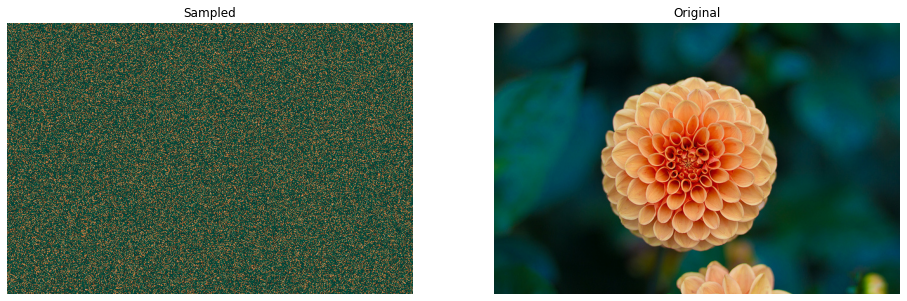

In [113]:
# Sample pixels and reshape them into the size of the original image
X_sampled = gmm_sample(np.prod(X.shape[:-1]), pi, mu, sigma).reshape(X.shape).astype(np.uint8)

# Compare the original and the sampled image
compare_images(X, X_sampled, "Sampled")

Explain what you see in the generated images. (1-3 sentences)

We can see plenty of noise. 
The distribution of the colors remains the same as in the reconstructed image.
The means of the cluster were ignored.